In [1]:
import numpy as np
import seaborn as sns
import pylab as plt

%matplotlib inline

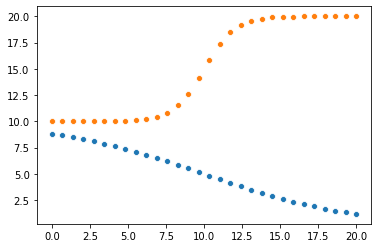

In [2]:
n_parts = 5

ka = np.zeros(n_parts)
ka[0] = 1

def sigmoid(x, a, kd, n, offset, inv):
    return a - (a) / (1. + np.exp((-x + kd)*n*inv)) + offset


x = np.linspace(0, 20, 30)
y = sigmoid(x, 10, 10, 0.2, 0,  1)
sns.scatterplot(x=x, y=y)
x = np.linspace(0, 20, 30)
y = sigmoid(x, 10, 10, 1,   10, -1)
sns.scatterplot(x=x, y=y)

In [3]:
np.random.choice([1, -1], 5)

array([-1, -1,  1,  1, -1])

In [4]:
np.random.randint(0, 2, 5)

array([1, 1, 1, 0, 0])

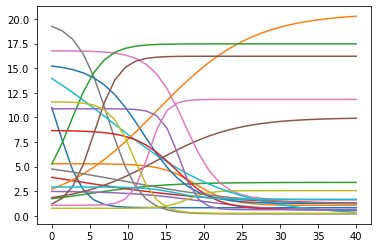

In [5]:
num = 20

A = np.random.uniform(1, 20, size=(num))
K = np.random.uniform(1, 20, size=(num))
n = np.random.uniform(0.1, 1, size=(num))
o = np.random.uniform(0, A.max() / 10., size=(num))


A = np.expand_dims(A, 1)
K = np.expand_dims(K, 1)
n = np.expand_dims(n, 1)
o = np.expand_dims(o, 1)

# choose repressor (1) or activator (-1)
i = np.random.choice([1, -1], (num, 1))

# [n_parts, n_params]
params = np.hstack([A, K, n, o, i])
x = np.repeat(np.expand_dims(np.linspace(0, 40, 30), 0), num, axis=0)
y = sigmoid(x, *tuple(np.expand_dims(params.T, 2)))

plt.plot(x.T, y.T);

In [6]:
import networkx as nx

g = nx.DiGraph()
g.add_edge(0, 1)
g.add_edge(1, 2)
g.add_edge(2, 3)
x = np.linspace(0, 30, 30)

def sigmoid_partial(x, node):
    return sigmoid(x, *tuple(np.expand_dims(params[node:node+1].T, 2)))


def steady_state(g, acc='sum', node_to_part = lambda x: int(x)):
    acc_dict = {
        'sum': lambda x: np.sum(np.concatenate(x))
    }
    
    # in topological order, we evaluate the sigmoid function at each node
    for node in nx.topological_sort(g):
        
        idx = node_to_part(node)
        # gather all parents
        # accumulate outputs 'y' using the provided accumulation function
        parents = list(g.predecessors(node))
        if not parents:
            p = np.expand_dims(params[idx:idx+1].T, 2)
            x = np.array([[0.]])
        else:
            a = []
            for p in parents:
                _x = g.nodes[p]['y']
                a.append(_x)
            x = acc_dict[acc](a)
            x = x.reshape(_x.shape)
        y = sigmoid_partial(x, idx)
#         if 'y' in g.nodes[node]:
#             g.nodes[node]['y'] += y
#         else:
        g.nodes[node]['y'] = y
        

for _ in range(5):
    steady_state(g, node_to_part = lambda x: int(x))
    out = []
    for n, ndata in g.nodes(data=True):
        out.append(ndata['y'])
    print(np.array(out).flatten())

[10.99169141  5.16971804  2.28481732  3.62954952]
[10.99169141  5.16971804  2.28481732  3.62954952]
[10.99169141  5.16971804  2.28481732  3.62954952]
[10.99169141  5.16971804  2.28481732  3.62954952]
[10.99169141  5.16971804  2.28481732  3.62954952]


In [7]:
from itertools import permutations
from typing import *
from functools import partial

def has_cycle(g):
    try:
        nx.find_cycle(g)
        return True
    except nx.NetworkXNoCycle:
        return False

def random_circuit(part_range):
    g = nx.DiGraph()
    n = np.random.randint(1, 10)
    nodes = np.random.randint(0, 20, size=(n, 3))
    for n1, n2 in permutations(nodes, r=2):
        if n1[-1] in (n2[0], n2[1]):
            g.add_edge(tuple(n1), tuple(n2))
    return g

def iter_random_circuit(limit, part_range: Tuple[int, int], cycles: bool = True):
    new_circuit = partial(random_circuit, part_range=part_range)
    for i in range(limit):
        c = new_circuit()
        if cycles is True:
            yield c
        else:
            while has_cycle(c):
                c = new_circuit()
            yield c

In [8]:
import torch

def to_one_hot(arr, mx):
  oh = torch.zeros((arr.shape[0], mx))
  for i, a in enumerate(arr):
    oh[i, a] = 1.0
  return oh

one_hot_encoded = to_one_hot(torch.arange(0, 20), 20)

In [9]:
import torch
from tqdm.auto import tqdm

def add_features(g):
    new_g = nx.DiGraph()
    for n, data in g.nodes(data=True):
        new_g.add_node(n, **data)
    for n1, n2, edata in g.edges(data=True):
        edata['features'] = np.array([0.])
        edata['target'] = np.array([1.])
        new_g.add_edge(n1, n2, **edata)
    steady_state(new_g, node_to_part= lambda x: x[-1])
    for n, ndata in new_g.nodes(data=True):
        # convert this to ONE HOT!
        ndata['features'] = one_hot_encoded[list(n)[-1]]
        ndata['target'] = torch.tensor([ndata['y'].flatten()], dtype=torch.float)
    new_g.data = {
        'features': torch.tensor([0]),
        'target': torch.tensor([0])
    }
    return new_g
        


In [10]:
import itertools

class Augment:
    
    @staticmethod
    def add_all_edges(g):
        nodes = list(g.nodes())
        for n1, n2 in itertools.product(nodes, repeat=2):
            if n2 not in g[n1] or g[n1][n2] is None or len(g[n1][n2]) == 0:
                g.add_edge(n1, n2, features=torch.tensor([0.]), target=torch.tensor([0.]))
        return g

In [11]:
from pyrographnets.data import GraphBatch, GraphDataLoader
graphs = [add_features(g) for g in iter_random_circuit(3000, (2, 3), cycles=False)]

[Augment.add_all_edges(g) for g in tqdm(graphs)]

batch = GraphBatch.from_networkx_list(graphs, n_edge_feat=1, n_node_feat=20, n_glob_feat=1)
test_batch = GraphBatch.from_networkx_list(graphs, n_edge_feat=1, n_node_feat=1, n_glob_feat=1, feature_key='target')
datalist = batch.to_data_list()
testdatalist = test_batch.to_data_list()

## Check Graphs

(16, 11, 5) {'y': array([[1.97795022]]), 'features': tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), 'target': tensor([[1.9780]])}
(13, 5, 18) {'y': array([[11.54990047]]), 'features': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.]), 'target': tensor([[11.5499]])}
(1, 8, 16) {'y': array([[1.07179335]]), 'features': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.]), 'target': tensor([[1.0718]])}
(0, 16, 15) {'y': array([[1.61111548]]), 'features': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0.]), 'target': tensor([[1.6111]])}
(11, 10, 17) {'y': array([[4.75474535]]), 'features': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.]), 'target': tensor([[4.7547]])}
(10, 17, 15) {'y': array([[6.53395882]]), 'features': tensor([0., 0., 0., 0., 0., 0., 0., 0.,

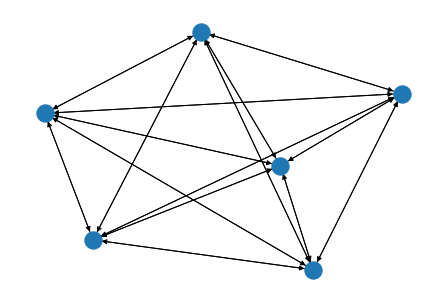

In [12]:
nx.draw(graphs[0])
for n, ndata in graphs[0].nodes(data=True):
    print(n, ndata)
    
for n1, n2 in graphs[0].edges():
    print(n1, n2)

In [17]:
for a, b in GraphDataLoader(list(zip(datalist, testdatalist)), batch_size=32):
    pass

In [18]:
from typing import List

from torch import nn

from pyrographnets.utils import pairwise


class MLPBlock(nn.Module):
    """A multilayer perceptron block."""

    def __init__(self, input_size: int, output_size: int = None):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.blocks = nn.Sequential(
            nn.Linear(input_size, output_size), nn.ReLU(), nn.LayerNorm(output_size)
        )

    def forward(self, x):
        return self.blocks(x)


class MLP(nn.Module):
    """A multilayer perceptron."""

    def __init__(self, *latent_sizes: List[int]):
        super().__init__()
        self.blocks = nn.Sequential(
            *[MLPBlock(n1, n2) for n1, n2 in pairwise(latent_sizes)]
        )

    def forward(self, x):
        return self.blocks(x)

In [25]:
from pyrographnets.models import GraphEncoder, GraphCore
from pyrographnets.blocks import EdgeBlock, NodeBlock, GlobalBlock, AggregatingEdgeBlock, AggregatingGlobalBlock, AggregatingNodeBlock, Aggregator
from pyrographnets.blocks import Flex
from pyrographnets.blocks import MLP




class Network(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        latent_size = 16
        
        layers = (latent_size, latent_size, 1)
        
        self.encoder = GraphEncoder(
            EdgeBlock(MLP(1, layers[0])),
            NodeBlock(MLP(20, layers[1])),
            GlobalBlock(MLP(1, layers[2]))
        )
        
        self.core = GraphCore(
            AggregatingEdgeBlock(torch.nn.Sequential(
                Flex(MLP)(Flex.d(), latent_size, latent_size, layers[0]),
#                 torch.nn.Linear(layers[0], layers[0])
            )),
            AggregatingNodeBlock(torch.nn.Sequential(
                Flex(MLP)(Flex.d(), latent_size, latent_size, layers[1]),
#                 torch.nn.Linear(layers[1], layers[1])
            ), Aggregator('add')),
            AggregatingGlobalBlock(Flex(MLP)(Flex.d(), layers[2]), Aggregator('add'), Aggregator('add'))
        )
        
        self.decoder = GraphEncoder(
            EdgeBlock(Flex(MLP)(   Flex.d(),   latent_size, layers[0])),
            NodeBlock(Flex(MLP)(   Flex.d(),   latent_size, layers[1])),
            GlobalBlock(Flex(MLP)( Flex.d(),   layers[2]))
        )
                
        self.output_transform = GraphEncoder(
            EdgeBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
            NodeBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
            GlobalBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
        )
        
    def forward(self, data, steps):

        # encoded
        e, x, g = self.encoder(data)
        data = GraphBatch(x, e, g, data.edges, data.node_idx, data.edge_idx)
        
        # graph topography data
        edges = data.edges
        node_idx = data.node_idx
        edge_idx = data.edge_idx
        latent0 = data
        
        outputs = []
        for _ in range(steps):
            # core processing step
            e = torch.cat([latent0.e, e], dim=1)
            x = torch.cat([latent0.x, x], dim=1)
            g = torch.cat([latent0.g, g], dim=1)
            data = GraphBatch(x, e, g, edges, node_idx, edge_idx)
            e, x, g = self.core(data)
        
            # decode 
            data = GraphBatch(x, e, g, edges, node_idx, edge_idx)
            _e, _x, _g = self.decoder(data)
            decoded = GraphBatch(_x, _e, _g, edges, node_idx, edge_idx)
            
            # transform
            _e, _x, _g = self.output_transform(decoded)
            outputs.append(GraphBatch(_x, _e, _g, edges, node_idx, edge_idx))
            
        # revise connectivity
        
        return outputs
        
net = Network()

# for samples in loader:
# #     print(samples[0].x.shape)
#     out = net(samples[0], 10)

In [29]:
class NewNetwork(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net1 = Network()
        self.select_edges = Flex(Select)(Flex.d(), Flex.d())
        self.net2 = Network()
        
    def forward(self, data, steps1, steps2 = None):
        if steps2 is None:
            steps2 = steps1
        outputs = self.net1(data, steps1)
        a = self.edge_select(outputs[-1].e)
        b = torch.round(a).long().flatten()
        c = torch.where(b == 1)[0]
        edges = data.edges[:, torch.where(b == 1)[0]]
        _data = GraphBatch(data.x, data.e, data.g, edges, data.node_idx, data.edge_idx)
        return self.net2(_data, steps2)
    
model = NewNetwork()

for samples in loader:
    pass
model(samples[0], 10)

NameError: name 'Select' is not defined

In [21]:
edges = torch.randint(0, 10, (2, 20))
torch.where(torch.randint(0, 3, (20,)) == 1)[0]

tensor([ 0,  1,  6,  7,  8, 11, 12, 13, 15])

In [22]:
class Foo(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.blocks = torch.nn.Sequential(
            torch.nn.Linear(8, 8),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        a = torch.round(self.blocks(x))
        
        return x[a.long()]
    
foo = Foo()

# x = torch.randn(10, 8)
# x.requires_grad = True
# print(x)


foo(x)

# torch.scatter(0, )

# x[torch.randint(0, 10, (2,))]

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [23]:
# new data
graphs = [add_features(g) for g in iter_random_circuit(3000, (2, 20), cycles=False)]

# augment by adding all edges

# augmenting edges results in loss of learning ability
[Augment.add_all_edges(g) for g in tqdm(graphs)]

batch = GraphBatch.from_networkx_list(graphs, n_edge_feat=1, n_node_feat=20, n_glob_feat=1)
test_batch = GraphBatch.from_networkx_list(graphs, n_edge_feat=1, n_node_feat=1, n_glob_feat=1, feature_key='target')
datalist = batch.to_data_list()
testdatalist = test_batch.to_data_list()

# train_datalist = graphs[:2500]
# test_datalist = graphs[2500:]

all_data = list(zip(datalist, testdatalist))
print(len(datalist))
x = int(len(all_data)*0.9)
loader = GraphDataLoader(all_data[:x], batch_size=254, shuffle=True)
eval_loader = GraphDataLoader(all_data[x:], batch_size=len(all_data[x:]), shuffle=False)

for a, b in eval_loader:
    pass
assert a


1917


In [24]:
from pyrographnets.utils.tensorboard import new_writer
from pyrographnets.data import GraphBatch, GraphDataLoader
from tqdm.auto import tqdm
from pyrographnets.utils import _first

device = 'cuda:0'

# new tensorboard writer
writer = new_writer('runs/circuit_seq')

# new model
net = Network()

with torch.no_grad():
    batch, _ = _first(loader)
    print(batch.shape)
    out = net(batch, 3)
%matplotlib inline
# print(out.x)
net.to(device)

optimizer = torch.optim.AdamW(net.parameters(), lr=0.002, weight_decay=1e-1)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.0009)
loss_fn = torch.nn.MSELoss()

def to(batch, device):
    return GraphBatch(
        batch.x.to(device),
        batch.e.to(device),
        batch.g.to(device),
        batch.edges.to(device),
        batch.node_idx.to(device),
        batch.edge_idx.to(device)
    )

import pandas as pd

def plot(target_data, out):
    x = target_data.x.cpu().detach().numpy().flatten()
    y = out.x.cpu().detach().numpy().flatten()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    df = pd.DataFrame({'x': x, 'y': y})
    ax = sns.scatterplot('x', 'y', data=df, ax=ax)
    ax.set_ylim(-5, 20)
    ax.set_xlim(-5, 20)
    return ax, fig

# training
net.train()
for epoch in tqdm(range(3000)):
    net.train()
    running_loss = 0.
    for batch_idx, (train_data, target_data) in enumerate(loader):
#             test_data = batch.mask(*test_mask)
#             target_data = batch.mask(*test_mask, invert=True)
        train_data = to(train_data, device)
        target_data = to(target_data, device)
        out = net(train_data, 10)
        assert out[-1].x.shape == target_data.x.shape
        
        optimizer.zero_grad()
        
        loss = torch.tensor(0.).to(device)
        for _out in out:
            loss += loss_fn(_out.x, target_data.x)
#             loss += torch.nn.BCEWithLogitsLoss(_out.e, target_data.e)
        loss = loss / len(out) / loader.batch_size
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    writer.add_scalar('test loss', running_loss, epoch)
#         loss2 = loss_fn(out.)
#             out = model(test_data.g, test_data.x, test_data.e, test_data.edges, test_data.node_idx, test_data.edge_idx)
#             loss = loss_fn(out, target_data.g)

#             loss.backward()

#             optimizer.step()

#             running_loss += loss.item()

#         writer.add_scalar('test loss', running_loss, epoch)

    if epoch % 10 == 0:
        eval_loss = 0.
        net.eval()
        with torch.no_grad():
            for eval_data, eval_target in eval_loader:
                eval_data = to(eval_data, device)
                eval_target = to(eval_target, device)
                eval_outs = net(eval_data, 20)
                eval_loss += loss_fn(eval_outs[-1].x, eval_target.x) / eval_loader.batch_size
#                 eval_loss += loss_fn(eval_outs[-1].e, eval_target.e) / eval_loader.batch_size
            writer.add_scalar('eval loss', eval_loss, epoch)
    
        with torch.no_grad():
            ax, fig = plot(eval_target, net(eval_data, 10)[-1])
            writer.add_figure('compare', fig, epoch)
                
#     if epoch % 10 == 0:
#         net.eval()
#         with torch.no_grad():
#             ax, fig = plot(target_data, net(train_data, 10)[-1])
#             writer.add_figure('compare', fig, epoch)

#     if epoch % 1 == 0:
# #         k = 'core.node_block.block_dict.mlp.resolved_module.blocks.0.blocks.0.weight'
# #         writer.add_histogram(k, net.state_dict()[k])
#         writer.add_histogram('out', out[-1].x)
        


New writer at 'runs/circuit_seq0152'
torch.Size([20, 1, 1])


KeyboardInterrupt: 

In [ ]:
latent0 = torch.randn(1, 5)
latent0.requires_grad = True
print(latent0.requires_grad)

a = torch.nn.Sigmoid()(latent0 * 50)
a.requires_grad
# torch.round(a)
print(a.shape)
edges = torch.randint(0, 20, (2, 5))
print(edges.shape)
r = torch.round(a)
c = edges * torch.round(r)

i = torch.where(r == 0)
print(r)
# torch.where(torch.round(a) == 1)[0]

In [ ]:
torch.select

In [197]:
torch.select(b, torch.round(a))

TypeError: select() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (Tensor input, name dim, int index)
 * (Tensor input, int dim, int index)


In [ ]:
# TODO: differentiable mask for connectivity

In [ ]:
net.eval()
with torch.no_grad():
    out = net(train_data, 10)
    plot(target_data, out)

In [ ]:
out.x.shape

In [ ]:
target_data.x[:20]

In [ ]:
out.x[:20]


In [ ]:
g = nx.OrderedMultiDiGraph()

In [ ]:
g.add_edge(100, 14554)

g.add_edge(10, 1, features="first")


g.add_edge(100, 14554)
out = g.add_edge(10, 1, features='second')
print(out)
for n1, n2 in g.edges():
    print(n1, n2)

In [ ]:
target_data.x

In [ ]:
list(g.edges)